# Epicurious Data Analysis

**Autor:** Raphael Brito Alencar

**Descrição:** Análise dos dados coletados do site https://www.epicurious.com/

In [1]:
# carregando libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, probplot

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize
import re

import json
import gc

%matplotlib inline

[nltk_data] Downloading package punkt to /home/raphael-b-
[nltk_data]     alencar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raphael-b-alencar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Utils
# percentual de preenchimento de cada feature
def show_filling_factor(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = ((data.shape[0] - missing_df['missing values']) / data.shape[0]) * 100
    return missing_df.sort_values('filling factor (%)').reset_index(drop = True)

# histograma e normal probability plot
def create_hist_prob_plot(ser):
    sns.distplot(ser, fit=norm);
    fig = plt.figure()
    res = probplot(ser, plot=plt)
    
# transformar para log
def log_transform(ser):
    return ser.map(lambda i: np.log(i) if i > 0 else 0)

def fillna_outlier_mean(col):
    # substituindo valores de outliers pela media
    IQR = iqr(data[col], nan_policy='omit')
    upper_bound = data[col].quantile(0.75) + 1.5 * IQR
    lower_bound = data[col].quantile(0.25) - 1.5 * IQR
    
    outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)]
    outliers_idx = outliers.index
    
    mean = data[~data.isin(outliers)][col].mean()
    
    data.loc[outliers_idx, col] = mean
    data[col].fillna(mean, inplace=True)
    
    return data[col].describe().round(decimals=2).drop('count')


def count_sublist_values(data,sublist):
    series = list()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                series.append(j)
        except:
            pass
    return pd.Series(series)

def sublist_uniques(data,sublist):
    categories = set()
    for i in data.index:
        try:
            t = data.loc[i, sublist]
            for j in t:
                categories.add(j)
        except:
            pass
    return list(categories)

def sublists_to_binaries(data, sublist, index_key = None):
    categories = sublist_uniques(data,sublist)
    frame = pd.DataFrame(columns=categories)
    for i in data.index:
        if type(data.loc[i, sublist]) == list or np.array:
            try:
                if index_key != None:
                    key = data.loc[i, index_key]
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    if key in frame.index:
                        for j in data.loc[i, sublist]:
                            frame.loc[key][j]+=1
                    else:
                        frame.loc[key]=f
                else:
                    f = np.zeros(len(categories))
                    for j in data.loc[i, sublist]:
                        f[categories.index(j)] = 1
                    frame.loc[i]=f
            except:
                pass
                
    return frame

In [3]:
# carregando dados de receitas.json
# verificando os primeiros registros
data = pd.read_json('receitas.json')
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [4]:
data.shape

(20130, 11)

In [5]:
# informações sobre as colunas do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [6]:
# descrevendo estatísticas dos valores numéricos
# resultado sem dados tratados
data.describe().round(decimals=2)

,fat,calories,protein,rating,sodium
count,15908.00,15976.00,15929.00,20100.00,15974.00
mean,346.10,6307.86,99.95,3.71,6211.47
std,20431.02,358585.12,3835.62,1.34,332890.25
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,198.00,3.00,3.75,80.00
50%,17.00,331.00,8.00,4.38,294.00
75%,33.00,586.00,27.00,4.38,711.00
max,1722763.00,30111218.00,236489.00,5.00,27675110.00


Alguns fatos observados na descrição estatística das features:
* Temos valores extremos para fat, calories, protein e sodium
* Um alto numero de ratings 4.38, o que parece um erro

In [7]:
# verificando registros duplicados
print('Número de receitas duplicadas: {}'.format(data.duplicated('title').sum()))

Número de receitas duplicadas: 2354


In [8]:
# removendo registros duplicados
data.drop_duplicates('title', keep='first', inplace=True)
data.shape

(17776, 11)

In [9]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5859,67.039829
1,fat,3732,79.005401
2,protein,3713,79.112286
3,sodium,3689,79.247300
4,calories,3688,79.252925
5,rating,10,99.943744
6,directions,1,99.994374
7,date,1,99.994374
8,categories,1,99.994374
9,title,1,99.994374


Olhando a tabela acima, parece que os registros nulos são os mesmos para categories, date, directions, ingredients e title. No caso, 1 registro. Verificando:

In [10]:
# tratando valores nulos
data[data['categories'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# excluindo registros totalmente nulos
data.drop(data[data['categories'].isna()].index, inplace=True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,fat,3731,79.009845
2,protein,3712,79.116737
3,sodium,3688,79.251758
4,calories,3687,79.257384
5,rating,9,99.949367
6,directions,0,100.000000
7,date,0,100.000000
8,categories,0,100.000000
9,title,0,100.000000


Ao que parece, quando o valor de sodium não está preenchido, o valor de calories também não é preenchido. Apenas em um casos que isso não acontece:

In [12]:
# not_null_calories = data[data['calories'].notnull()]
# not_null_calories[not_null_calories['sodium'].isna()]

In [13]:
# preenchendo os dois valores com a mediana dos valores de sodio onde o valor de calorias é 4.0
# q = 'calories == 4.0'
# data.query(q)['sodium'].median()
# data.loc[not_null_calories[not_null_calories['sodium'].isna()].index, 'sodium'] = data.query(q)['sodium'].median()

In [14]:
# data.loc[not_null_calories[not_null_calories['sodium'].isna()].index, 'sodium']

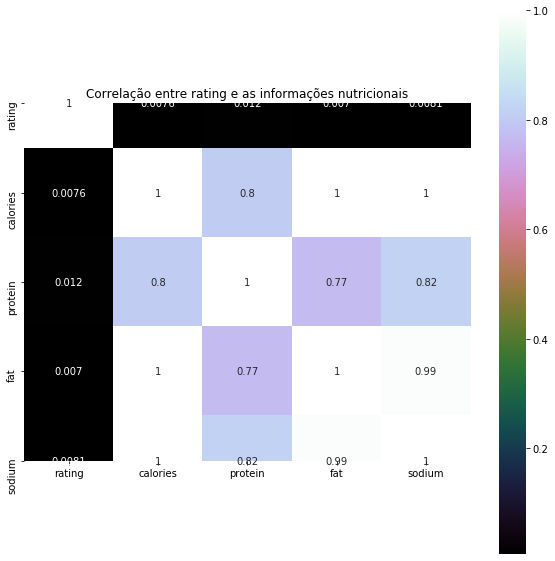

In [15]:
# verificando correlação entre variaveis numericas
cols = ['rating', 'calories', 'protein', 'fat', 'sodium']

plt.figure(figsize=(10,10))
sns.heatmap(data[cols].corr(), vmax=1, square=True,annot=True,cmap='cubehelix')
plt.title('Correlação entre rating e as informações nutricionais')
plt.show()

Percebe-se que os valores se correlacionam de forma positiva. 

In [16]:
# preenchendo os valores numericos com KNNImputer
# esse passo pode ser revisitado caso precise melhorar a acurácia do modelo de classificação
# from sklearn.impute import KNNImputer

# data_to_transform = data[cols]

# imputer = KNNImputer(n_neighbors=3, copy=False)
# imputer.fit_transform(data_to_transform)
# data_to_transform.head()

In [17]:
# data[cols] = data_to_transform.round(decimals=1)
# show_filling_factor(data)

In [18]:
# dropando colunas, a principio, desnecessária
# cols = ['desc', 'directions', 'date', 'title']

# data.drop(cols, axis=1, inplace=True)
# show_filling_factor(data)

In [19]:
# Onehot encoding categorias e concatenar ao data
# cat = sublists_to_binaries(data, 'categories')
# data = pd.concat([data, cat], axis=1)

# data.drop(columns='categories', inplace=True)
# data.head()

### fat

In [20]:
data['fat'].describe().round(decimals=2).drop('count')

mean        373.37
std       21664.16
min           0.00
25%           9.00
50%          18.00
75%          35.00
max     1722763.00
Name: fat, dtype: float64

In [21]:
# preenchendo valores faltantes e outliers com media
fillna_outlier_mean('fat')

mean    20.83
std     14.78
min      0.00
25%     11.00
50%     20.83
75%     24.00
max     74.00
Name: fat, dtype: float64

In [22]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,protein,3712,79.116737
2,sodium,3688,79.251758
3,calories,3687,79.257384
4,rating,9,99.949367
5,directions,0,100.000000
6,fat,0,100.000000
7,date,0,100.000000
8,categories,0,100.000000
9,title,0,100.000000


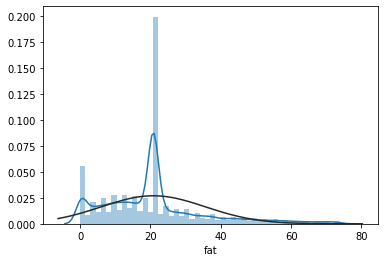

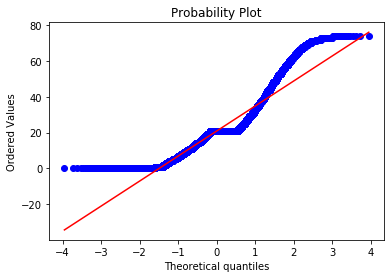

In [23]:
create_hist_prob_plot(data['fat'])

In [24]:
# skewness and kurtosis
print("Skewness: %f" % data['fat'].skew())
print("Kurtosis: %f" % data['fat'].kurt())

Skewness: 1.156715
Kurtosis: 1.644323


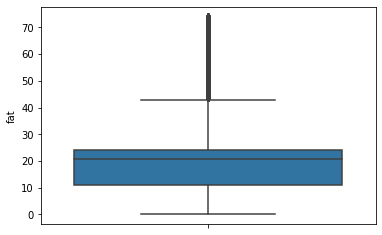

In [25]:
# detectando outliers
sns.boxplot(y=data['fat'])
plt.show()

### protein

In [26]:
data['protein'].describe().round(decimals=2).drop('count')

mean        94.57
std       3562.18
min          0.00
25%          3.00
50%          9.00
75%         29.00
max     236489.00
Name: protein, dtype: float64

In [27]:
# preenchendo valores faltantes e outliers com media
fillna_outlier_mean('protein')

mean    15.15
std     13.99
min      0.00
25%      5.00
50%     15.15
75%     16.00
max     68.00
Name: protein, dtype: float64

In [28]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,sodium,3688,79.251758
2,calories,3687,79.257384
3,rating,9,99.949367
4,directions,0,100.000000
5,fat,0,100.000000
6,date,0,100.000000
7,categories,0,100.000000
8,protein,0,100.000000
9,title,0,100.000000


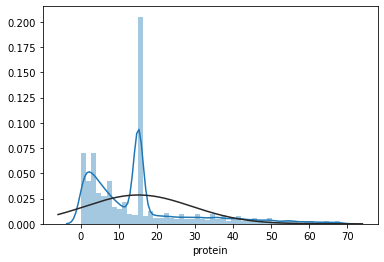

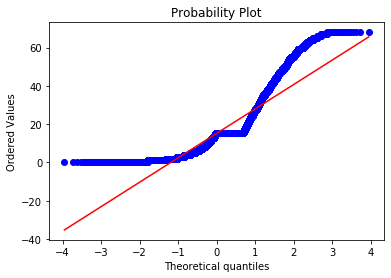

In [29]:
create_hist_prob_plot(data['protein'])

In [30]:
# skewness and kurtosis
print("Skewness: %f" % data['protein'].skew())
print("Kurtosis: %f" % data['protein'].kurt())

Skewness: 1.527584
Kurtosis: 2.132793


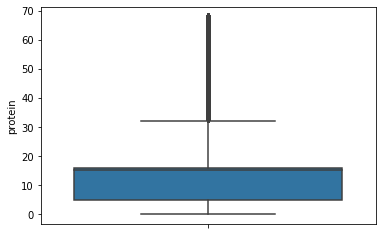

In [31]:
sns.boxplot(y=data['protein'])
plt.show()

### calories

In [32]:
data['calories'].describe().round(decimals=2).drop('count')

mean        6806.13
std       380247.67
min            0.00
25%          208.00
50%          351.00
75%          605.00
max     30111218.00
Name: calories, dtype: float64

In [33]:
# preenchendo valores faltantes e outliers com media
fillna_outlier_mean('calories')

mean     395.06
std      223.53
min        0.00
25%      242.00
50%      395.06
75%      460.00
max     1200.00
Name: calories, dtype: float64

In [34]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,sodium,3688,79.251758
2,rating,9,99.949367
3,directions,0,100.000000
4,fat,0,100.000000
5,date,0,100.000000
6,categories,0,100.000000
7,calories,0,100.000000
8,protein,0,100.000000
9,title,0,100.000000


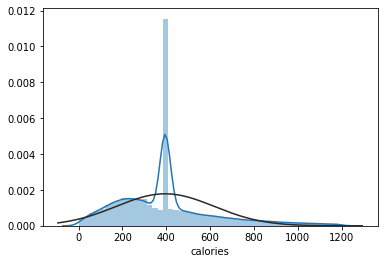

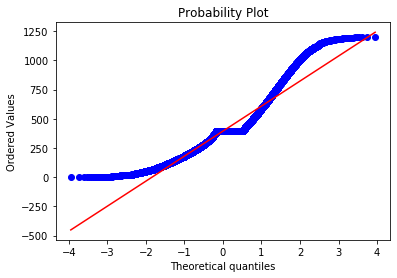

In [35]:
create_hist_prob_plot(data['calories'])

In [36]:
# skewness and kurtosis
print("Skewness: %f" % data['calories'].skew())
print("Kurtosis: %f" % data['calories'].kurt())

Skewness: 1.047934
Kurtosis: 1.355539


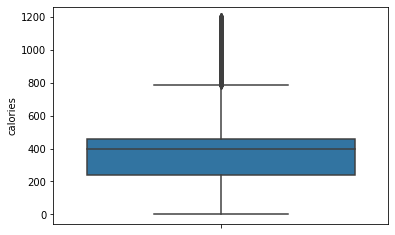

In [37]:
sns.boxplot(y=data['calories'])
plt.show()

### sodium

In [38]:
data['sodium'].describe().round(decimals=2).drop('count')

mean        6756.18
std       353498.62
min            0.00
25%           92.00
50%          310.00
75%          740.00
max     27675110.00
Name: sodium, dtype: float64

In [39]:
# preenchendo valores faltantes e outliers com media
fillna_outlier_mean('sodium')

mean     404.99
std      347.26
min        0.00
25%      137.00
50%      404.99
75%      462.00
max     1712.00
Name: sodium, dtype: float64

In [40]:
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,rating,9,99.949367
2,directions,0,100.000000
3,fat,0,100.000000
4,date,0,100.000000
5,categories,0,100.000000
6,calories,0,100.000000
7,protein,0,100.000000
8,title,0,100.000000
9,ingredients,0,100.000000


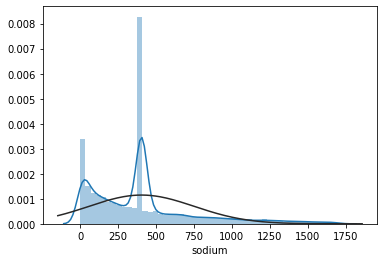

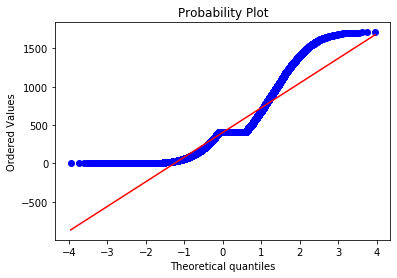

In [41]:
create_hist_prob_plot(data['sodium'])

In [42]:
# skewness and kurtosis
print("Skewness: %f" % data['sodium'].skew())
print("Kurtosis: %f" % data['sodium'].kurt())

Skewness: 1.376115
Kurtosis: 1.921805


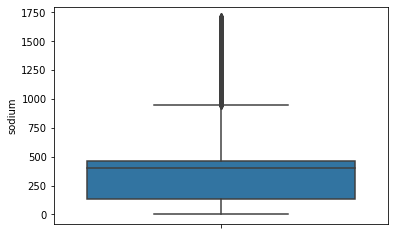

In [43]:
sns.boxplot(y=data['sodium'])
plt.show()

### rating

In [44]:
data['rating'].describe().round(decimals=2).drop('count')

mean    3.72
std     1.32
min     0.00
25%     3.75
50%     4.38
75%     4.38
max     5.00
Name: rating, dtype: float64

In [61]:
# preenchendo os valores faltantes de rating com a média 
data['rating'].fillna(data['rating'].mean(), inplace=True)
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,5858,67.043601
1,directions,0,100.000000
2,fat,0,100.000000
3,date,0,100.000000
4,categories,0,100.000000
5,calories,0,100.000000
6,protein,0,100.000000
7,rating,0,100.000000
8,title,0,100.000000
9,ingredients,0,100.000000


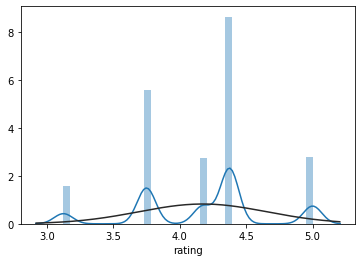

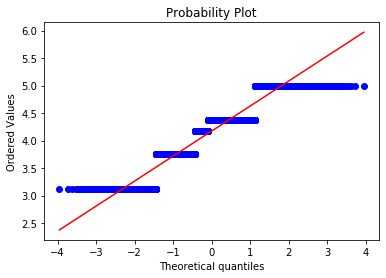

In [46]:
create_hist_prob_plot(data['rating'])

In [47]:
# skewness and kurtosis
print("Skewness: %f" % data['rating'].skew())
print("Kurtosis: %f" % data['rating'].kurt())

Skewness: -0.256993
Kurtosis: -0.081968


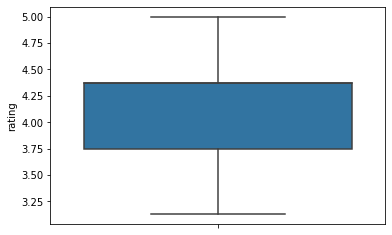

In [48]:
sns.boxplot(y=data['rating'])
plt.show()

### categories

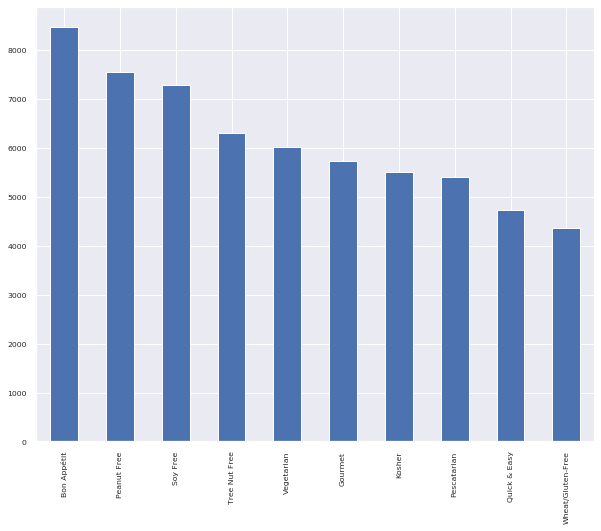

In [50]:
# Quantas vezes cada categoria aparece
cat = count_sublist_values(data, 'categories')

# plot top 10 categorias usadas
plt.figure(figsize=(10,8))
cat.value_counts().nlargest(10).plot.bar(5)
plt.show()

In [51]:
unique_cat = sublist_uniques(data, 'categories')
print('Um total de {} categorias'.format(len(unique_cat)))

Um total de 673 categorias


In [52]:
# 5 receitas mais caloricas e suas categorias
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_cat = count_sublist_values(cal_receipts, 'categories')
cal_receipts_unique_cat.value_counts()

Bon Appétit          4
Bake                 2
Dinner               2
Herb                 2
Soy Free             2
Pescatarian          2
Peanut Free          2
Walnut               2
Sauté                2
Clam                 1
Dessert              1
Pear                 1
Chill                1
Anniversary          1
Dairy Free           1
Seafood              1
Chicken              1
Egg                  1
Dairy                1
Squid                1
Lobster              1
Basil                1
Mussel               1
Valentine's Day      1
Low Carb             1
Noodle               1
Fruit                1
White Wine           1
Tree Nut Free        1
Kosher               1
Potato               1
Roast                1
Freeze/Chill         1
Citrus               1
Tomato               1
Slow Cooker          1
Lamb                 1
Olive                1
Cake                 1
Pumpkin              1
High Fiber           1
Ice Cream Machine    1
Cheese               1
Shrimp     

### ingredients

In [53]:
data.reset_index(drop=True, inplace=True)

# extraindo ingredientes de cada registro
recipe_ingredients = [] # armazena os ingredientes de cada receita
ingredients_list = [] # lista com todos ingredientes presentes nos dados

for i in range(len(data['ingredients'])):
    recipe_ingredients.append([])
    
    for j in range(len(data['ingredients'][i])):
        tokenized_ingredients = nltk.word_tokenize(data['ingredients'][i][j])
        
        # lista de tags https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html    
        tagged_ingredients = nltk.pos_tag(tokenized_ingredients)         
        tagged_ingredients = [k for k in tagged_ingredients if (k[1] == 'NN' or k[1] == 'NNS') and (re.match('[^0-9]', k[0]))]
        tagged_ingredients = tagged_ingredients[-1:]
        
        if len(tagged_ingredients) != 0:
            recipe_ingredients[i].append(tagged_ingredients[0][0]) # adicionando apenas o token
            ingredients_list.append(tagged_ingredients[0][0])

In [54]:
# Quais os top 10 ingredientes contidos nas receitas mais calóricas?
ingredients = pd.Series(recipe_ingredients, name='recipe_ingredients')
data = pd.concat([data, ingredients], axis=1)
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,recipe_ingredients
0,"[1. Place the stock, lentils, celery, carrot, ...",7.000000,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.000000,None,30.000000,4.173695,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.000000,"[stock, lentils, lentils, celery, carrot, thym..."
1,[Combine first 9 ingredients in heavy medium s...,23.000000,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.000000,This uses the same ingredients found in boudin...,18.000000,4.375000,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.000000,"[cream, onions, salt, leaves, cloves, clove, p..."
2,[In a large heavy saucepan cook diced fennel a...,7.000000,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.000000,None,6.000000,3.750000,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.000000,"[garnish, onion, butter, potatoes, broth, milk]"
3,[Heat oil in heavy large skillet over medium-h...,20.829886,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",395.056682,The Sicilian-style tomato sauce has tons of Me...,15.152385,5.000000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",404.991131,"[oil, onion, wine, paste, juice, fillets, oliv..."
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.000000,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.000000,None,20.000000,3.125000,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.000000,"[soufflé, noodles, cream, sauce, nutmeg, cheese]"


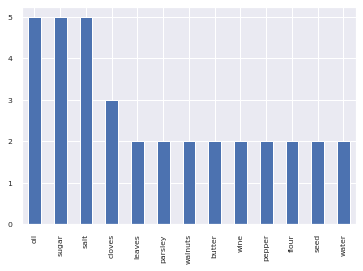

In [55]:
cal_receipts = data.nlargest(5, columns='calories')
cal_receipts_unique_ing = count_sublist_values(cal_receipts, 'recipe_ingredients')
cal_receipts_unique_ing.value_counts().nlargest(10, keep='all').plot.bar() 
plt.show()

Era de se esperar que sal e açucar fossem os ingredientes mais utilizados. 

In [56]:
# Considerando-se as categorias das top 100 receitas em avaliação, quantas receitas há atualmente no site https://www.epicurious.com para cada categoria
# usando as ultimas de acordo com a data
top_100_rating_recipe = data.sort_values('date', ascending=False).nlargest(100, columns='rating')
top_100_rating_recipe

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium,recipe_ingredients
4664,[Arrange a rack in center of oven; preheat to ...,65.000000,2016-11-27 18:46:20.583000+00:00,"[Vegetarian, Rice, Dinner, Orange, Parsnip, Ri...",935.000000,This simple rice salad combines hearty parsnip...,18.000000,5.0,Vegetarian Brown Rice Salad With Parsnips and ...,"[3/4 cup short-grain brown rice, 3/4 cup plus ...",1061.000000,"[rice, oil, salt, oranges, coins, clove, sprig..."
15619,"[Working one at a time, place turkey breast, s...",36.000000,2016-11-24 02:46:00+00:00,"[Friendsgiving, Thanksgiving, Dinner, Butternu...",631.000000,"For maximum juiciness and flavor, pound and se...",59.000000,5.0,"Stuffed Turkey Breast With Butternut Squash, K...","[2 (3-pound) skin-on, boneless turkey breasts,...",1335.000000,"[breasts, salt, pepper, fennel, oil, casings, ..."
8486,[Heat milk in a small saucepan over low until ...,5.000000,2016-11-23 20:30:00+00:00,"[Bread, Dinner, Christmas, Thanksgiving, Bake,...",122.000000,"One simple master recipe, based on a classic F...",2.000000,5.0,Dinner Rolls Six Ways,"[1/2 cup whole milk, 1 (1/4-ounce) envelope ac...",243.000000,"[milk, teaspoons, salt, flour, honey, tablespo..."
6323,[Heat butter and brown sugar in a small saucep...,26.000000,2016-11-22 17:36:17.100000+00:00,"[Bon Appétit, Thanksgiving, Pie, Sweet Potato/...",409.000000,We tested this pie recipe with canned sweet po...,6.000000,5.0,Sweet Potato–Miso Pie With Chocolate-Sesame Cr...,"[6 tablespoons unsalted butter, 1/4 cup (packe...",334.000000,"[butter, sugar, seeds, pieces, salt, pound, su..."
17265,"[Preheat oven to 300°F. Butter a shallow 13x9""...",36.000000,2016-11-21 23:33:04.148000+00:00,"[Bon Appétit, Thanksgiving, Stuffing/Dressing,...",549.000000,This holiday-worthy recipe was inspired by bre...,23.000000,5.0,Cheesy Sausage and Sage Stuffing,"[2 tablespoons unsalted butter, plus more, 1 m...",865.000000,"[butter, cups, oil, casings, onions, stalks, s..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13376,[Bring sugar and 1 cup water to a boil in a me...,20.829886,2016-05-19 19:15:11.511000+00:00,"[Bon Appétit, Cocktail, Punch, Tequila, Jalape...",395.056682,"We love the citrusy sour flavor of hibiscus, n...",15.152385,5.0,Pineapple-Hibiscus Cocktail,"[1 1/4 cups sugar, 1 pineapple, peeled, cut in...",404.991131,"[sugar, pieces, vinegar, flowers, rounds, mint..."
1249,[Preheat oven to 350°F. Toast sunflower seeds ...,19.000000,2016-05-19 17:42:56.460000+00:00,"[Bon Appétit, Cookies, Bake, Chocolate, Coconu...",312.000000,One of those dreamy cookies elicits a silent r...,4.000000,5.0,Double and By Double I Mean Triple Chocolate C...,"[1/2 cup raw sunflower seeds, 8 ounces bitters...",214.000000,"[seeds, chocolate, chocolate, flour, powder, p..."
1024,"[Preheat oven to 350°F. Lightly coat two 9""-di...",39.000000,2016-05-19 17:10:00.187000+00:00,"[Bon Appétit, Cake, Carrot, Spring, Spice, Cre...",738.000000,This is the only carrot cake recipe you’ll eve...,8.000000,5.0,BA's Best Carrot Cake,"[Nonstick vegetable oil spray, 1/2 cup golden ...",586.000000,"[spray, raisins, rum, walnuts, carrots, temper..."
16971,[Preheat oven to 275°F. Bring ancho chiles and...,20.829886,2016-05-19 15:14:18.076000+00:00,"[Bon Appétit, Dinner, Lamb, Braise, Chile Pepp...",395.056682,Though Birrieria Zaragoza in Chicago uses goat...,15.152385,5.0,Braised Birria,"[4 ounces ancho chiles (about 10), seeds remov...",404.991131,"[chiles, peanuts, seeds, peppercorns, powder, ..."


In [57]:
top_100_cat_recipe = count_sublist_values(top_100_rating_recipe, 'categories')

# top 100 categorias das top 100 receitas em avaliação
top_100_cat_recipe.value_counts().nlargest(100).index

Index(['Bon Appétit', 'Dinner', 'Summer', 'Peanut Free', 'Vegetarian',
       'Dessert', 'Soy Free', 'Tree Nut Free', 'Wheat/Gluten-Free',
       'Pescatarian', 'Kosher', 'Garlic', 'Thanksgiving', 'Chile Pepper',
       'HarperCollins', 'Tomato', 'Dairy Free', 'Salad', 'Chicken',
       'Lime Juice', 'Bake', 'No Sugar Added', 'Fall', 'Kidney Friendly',
       'Pork', 'Breakfast', 'Cilantro', 'Milk/Cream', 'Chocolate', 'Herb',
       'Roast', 'Ginger', 'Quick & Easy', 'Side', 'Pie', 'Bread', 'Lemon',
       'Coconut', 'Egg', 'Christmas', 'Butterscotch/Caramel', 'Fish', 'Brunch',
       'Sweet Potato/Yam', 'Appetizer', 'Basil', 'Braise', 'Seed', 'Cheese',
       'Lunch', 'Green Onion/Scallion', 'Winter', 'Mint', 'Peach', 'Spice',
       'Goat Cheese', 'Fennel', 'Coriander', 'Pasta', 'Cumin', 'Kale',
       'Soup/Stew', 'Grill', 'Buttermilk', 'Hot Pepper', 'Ice Cream', 'Almond',
       'Sugar Conscious', 'Capers', 'Lemon Juice', 'Butternut Squash',
       'Seafood', 'Corn', 'Cucumber', 'Q

In [58]:
cat100 = top_100_cat_recipe.value_counts().nlargest(100).index
for cat in cat100:
    count = 0
    print(cat)
    for i in data.index:
        val = data.loc[i,'categories']
        if cat in val:
            count+=1
    print('{} receitas.\n'.format(count))

Bon Appétit
8470 receitas.

Dinner
2535 receitas.

Summer
3762 receitas.

Peanut Free
7564 receitas.

Vegetarian
6027 receitas.

Dessert
3153 receitas.

Soy Free
7279 receitas.

Tree Nut Free
6302 receitas.

Wheat/Gluten-Free
4357 receitas.

Pescatarian
5399 receitas.

Kosher
5511 receitas.

Garlic
1438 receitas.

Thanksgiving
1228 receitas.

Chile Pepper
210 receitas.

HarperCollins
117 receitas.

Tomato
1961 receitas.

Dairy Free
2853 receitas.

Salad
1432 receitas.

Chicken
1240 receitas.

Lime Juice
118 receitas.

Bake
4035 receitas.

No Sugar Added
2792 receitas.

Fall
2676 receitas.

Kidney Friendly
1955 receitas.

Pork
872 receitas.

Breakfast
677 receitas.

Cilantro
532 receitas.

Milk/Cream
1791 receitas.

Chocolate
769 receitas.

Herb
1490 receitas.

Roast
1173 receitas.

Ginger
1030 receitas.

Quick & Easy
4728 receitas.

Side
2710 receitas.

Pie
20 receitas.

Bread
428 receitas.

Lemon
982 receitas.

Coconut
337 receitas.

Egg
1599 receitas.

Christmas
897 receitas.

Butter

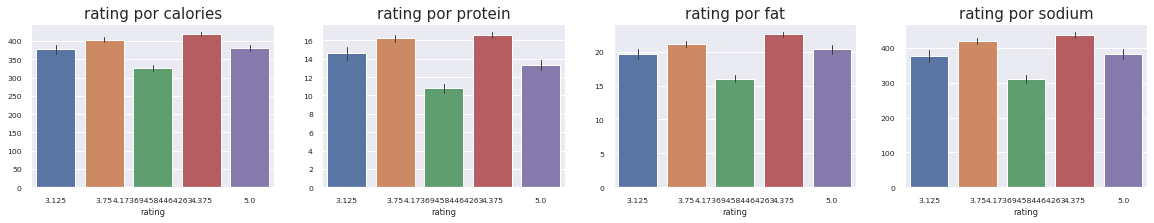

In [59]:
# Alguma característica presente nos dados determina a alta nota de uma receita?
dict_plt = {0:'calories',1:'protein',2:'fat',3:'sodium'}

sns.set(font_scale=.7)

fig, ax = plt.subplots(1,4, figsize=(20,3))

for i in range(4):
    sns.barplot(x='rating',y=dict_plt[i], data=data, ax=ax[i], errwidth=1)
    ax[i].set_title('rating por {}'.format(dict_plt[i]), size=15)
    ax[i].set_ylabel('')